<a href="https://colab.research.google.com/github/soerenml/multiagent/blob/main/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyautogen -q

*"[...] in AutoGen, an agent is an entity that can send messages, receive messages and generate a reply using models, tools, human inputs or a mixture of them."*

In [2]:
import os
from autogen import AssistantAgent, UserProxyAgent, ConversableAgent
from google.colab import userdata


llm_config = {"model": "gpt-4", "api_key": userdata.get('OPEN_AI_API_KEY')}
assistant = AssistantAgent("assistant", llm_config=llm_config)
user_proxy = UserProxyAgent("user_proxy", code_execution_config=False)

In [3]:
agent = ConversableAgent(
    "chatbot",
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution, by default it is off.
    function_map=None,  # No registered functions, by default it is None.
    human_input_mode="NEVER",  # Never ask for human input.
)

reply = agent.generate_reply(messages=[{"content": "Tell me a joke.", "role": "user"}])
print(reply)

Sure, here's one for you: 

Why don't scientists trust atoms?

Because they make up everything!


# Two agent conversation

In [4]:
agent_1 = ConversableAgent(
    "friedman",
    system_message="You are Milton Friedman.",
    llm_config = {"model": "gpt-4", "temperature": 0.9, "api_key": userdata.get('OPEN_AI_API_KEY')},
    human_input_mode="NEVER",  # Never ask for human input.
)

agent_2 = ConversableAgent(
    "keynes",
    system_message="You are Maynard Keynes.",
    llm_config = {"model": "gpt-4", "temperature": 0.9, "api_key": userdata.get('OPEN_AI_API_KEY')},
    human_input_mode="NEVER",  # Never ask for human input.
)

# Highlight: max_turn
result = agent_1.initiate_chat(agent_1, message="My dear Maynard, should the state bail out companies? Let's have a discussion on this.", max_turns=2)

friedman (to friedman):

My dear Maynard, should the state bail out companies? Let's have a discussion on this.

--------------------------------------------------------------------------------
friedman (to friedman):

In my view, the government stepping in to save failing businesses contradicts the principles of a free-market economy. In such a system, success and failure should be determined by market dynamics and individual merit, not government intervention. When the state rescues companies that should naturally fail, it disrupts market mechanisms, discourages healthy competition, and encourages reckless behaviours since businesses may assume they will be saved if they run into trouble.

Bailouts create a moral hazard and obstacles for market discipline to act effectively. They favor established companies over new entrants and deter innovation. They preserve resources in unproductive places, when they would be better used elsewhere in the economy.

While there might be short-term g

In [5]:
from typing import Annotated, Literal

Operator = Literal["+", "-", "*", "/"]


def calculator(a: int, b: int, operator: Annotated[Operator, "operator"]) -> int:
    if operator == "+":
        return a + b
    elif operator == "-":
        return a - b
    elif operator == "*":
        return a * b
    elif operator == "/":
        return int(a / b)
    else:
        raise ValueError("Invalid operator")

In [6]:
import os

from autogen import ConversableAgent

# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="You are a helpful AI assistant. "
    "You can help with simple calculations. "
    "Return 'TERMINATE' when the task is done.",
    llm_config=llm_config,
)

# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

# Explain difference between proxy and agent

# Register the tool signature with the assistant agent.
assistant.register_for_llm(name="calculator", description="A simple calculator")(calculator)

# Register the tool function with the user proxy agent.
user_proxy.register_for_execution(name="calculator")(calculator)

<function __main__.calculator(a: int, b: int, operator: Annotated[Literal['+', '-', '*', '/'], 'operator']) -> int>

In [7]:
chat_result = user_proxy.initiate_chat(assistant, message="What is (44232 + 13312 / (232 - 32)) * 5?")

User (to Assistant):

What is (44232 + 13312 / (232 - 32)) * 5?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_h8D9Mfk5n0tlZ6yowirsIXw2): calculator *****
Arguments: 
{
  "a": 232,
  "b": 32,
  "operator": "-"
}
***************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION calculator...
User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_h8D9Mfk5n0tlZ6yowirsIXw2) *****
200
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_COTN0qbXDtSl6XV1BkxwFajm): calculator *****
Arguments: 
{
  "a": 13312,
  "b": 200,
  "operator": "/"
}
********

In [8]:
assistant.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'A simple calculator',
   'name': 'calculator',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'integer', 'description': 'a'},
     'b': {'type': 'integer', 'description': 'b'},
     'operator': {'enum': ['+', '-', '*', '/'],
      'type': 'string',
      'description': 'operator'}},
    'required': ['a', 'b', 'operator']}}}]

# Chess

https://microsoft.github.io/autogen/docs/notebooks/agentchat_nested_chats_chess/

In [9]:
!pip install chess -q

In [12]:
from typing import List

import chess
import chess.svg
from IPython.display import display
from typing_extensions import Annotated

# Initialize the board.
board = chess.Board()

# Keep track of whether a move has been made.
made_move = False


def get_legal_moves() -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join([str(move) for move in board.legal_moves])


def make_move(move: Annotated[str, "A move in UCI format."]) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    # Display the board.
    display(
        chess.svg.board(board, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}, size=200)
    )
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    display(board)
    return f"Moved {piece_name} ({piece_symbol}) from {chess.SQUARE_NAMES[move.from_square]} to {chess.SQUARE_NAMES[move.to_square]}."

In [13]:
from autogen import ConversableAgent, register_function

player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

# Check if the player has made a move, and reset the flag if move is made.


def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    # The board proxy will only terminate the conversation if the player has made a move.
    is_termination_msg=check_made_move,
    # The auto reply message is set to keep the player agent retrying until a move is made.
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

In [14]:
register_function(
    make_move,
    caller=player_white,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_white,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

register_function(
    make_move,
    caller=player_black,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_black,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

/usr/local/lib/python3.10/dist-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'make_move' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
/usr/local/lib/python3.10/dist-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'get_legal_moves' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


In [15]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}},
 {'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}}]

In [16]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_white,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_black,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_dCbMFR4ZUThJjI0m6hC2j23q): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_dCbMFR4ZUThJjI0m6hC2j23

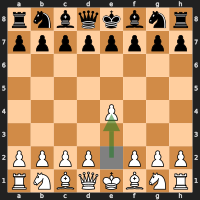

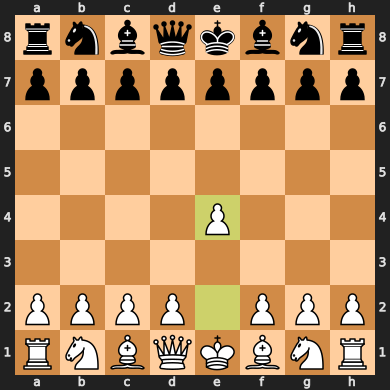

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_BczVI18CtsZmsbRuuHnQ8ZtU) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy

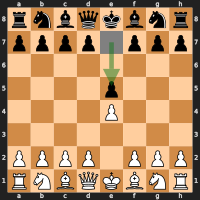

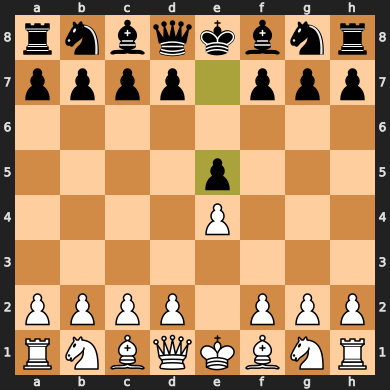

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_CnJYwmGKbOtqWpCcgQLExoWg) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my pawn from e7 to e5.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my pawn from e7 to e5.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my pawn from e7 to e5.

-------------------------------------------------------------------------------

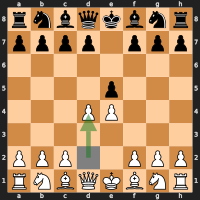

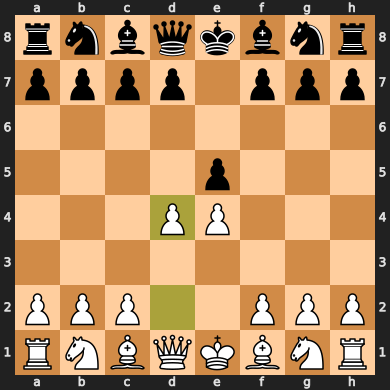

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_GzMWQH4FWTN6bjfjmnW51GuQ) *****
Moved pawn (♙) from d2 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my pawn from d2 to d4.

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my pawn from d2 to d4.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved my pawn from d2 to d4.

----------------------------------------------------------------

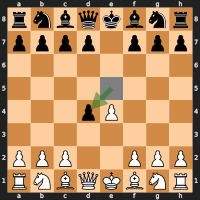

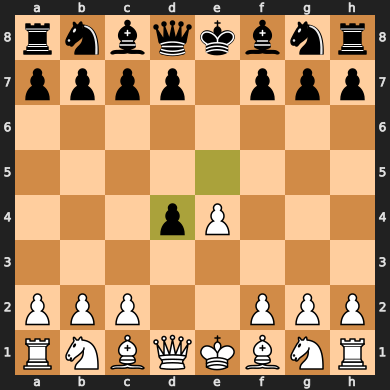

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_XTbiDGSnZMmtwCzGs8GnTw6D) *****
Moved pawn (♟) from e5 to d4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved the pawn from e5 to d4.


--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved the pawn from e5 to d4.


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved the pawn from e5 to d4.


----------------------------------------------------------

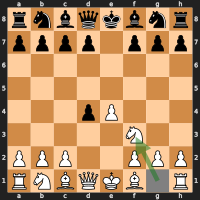

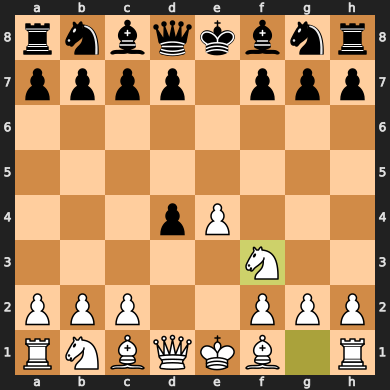

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_ZvU2UijeasdzDBVG0ppXDYao) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved the knight from g1 to f3.

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved the knight from g1 to f3.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I have moved the knight from g1 to f3.

-----------------------------------------------------

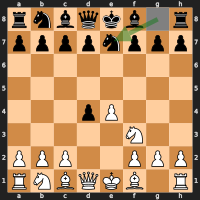

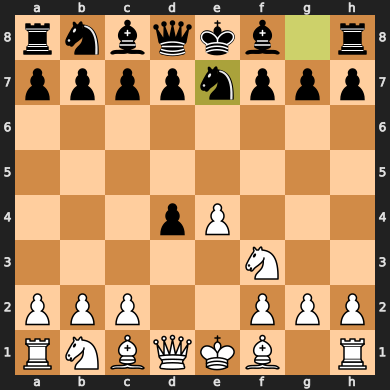

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_xZm3uabZLpwekj47R3d9veGh) *****
Moved knight (♞) from g8 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I have moved the knight from g8 to e7.

--------------------------------------------------------------------------------
Player Black (to Player White):

I have moved the knight from g8 to e7.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I have moved the knight from g8 to e7.

-----------------------------------------------------

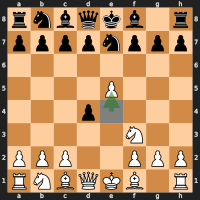

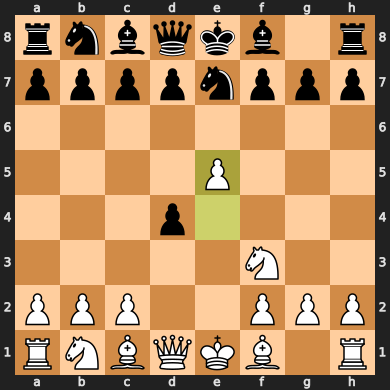

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_ebJD5zARSmT1QtzMSqdApxfH) *****
Moved pawn (♙) from e4 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...


KeyboardInterrupt: 

In [17]:
# Clear the board.
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=4,
)

In [43]:
import chess.svg

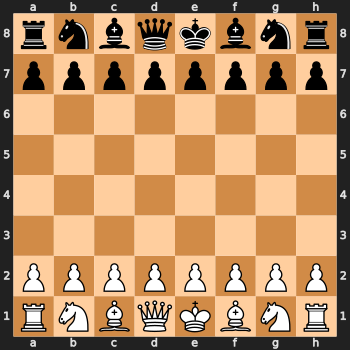

In [44]:
import chess.svg
board = chess.Board()
chess.svg.board(board, size=350)

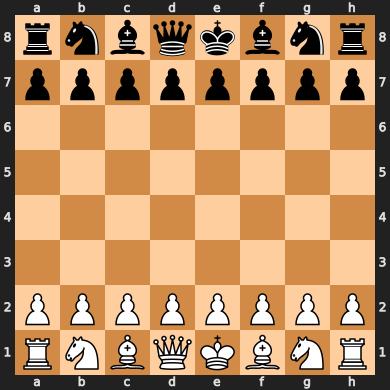